<a href="https://colab.research.google.com/github/yasnilamw/MSIB-K2-KelasAwanPintar/blob/main/22_10_24Student_Transfer_Learning_Diaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands On Coding Transfer Learning

Pada hands on coding ini, kita akan melakukan **Image Classification** 5 makanan lokal yaitu Bakso, Gado-gado, Gudeg, Rendang, dan Sate. Kita akan menggunakan Teknik **Transfer Learning** dengan menggunakan beberapa Pre-trained yang telah disediakan.

**NOTE: Pastikan mengaktifkan GPU dan terhubung dengan Google Drive!**

## Import Packages

Berikut adalah packages yang akan digunakan pada proyek ini. 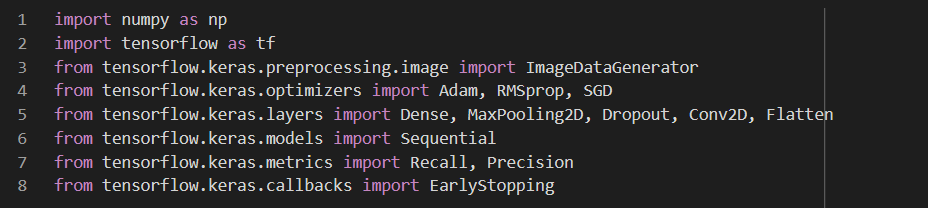

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping

## Import Dataset

Silakan hubungkan Google Colab kalian dengan Google Drive, kemudian extract zip file pada file dataset yang telah kalian upload sebelumnya pada Google Drive kalian

In [ ]:
# Jika belum mendownload, bisa download dengan perintah dibawah
!gdown 12aMkT21BxaTkf_FlPYS7fxzDZjunMv-O

Downloading...
From (original): https://drive.google.com/uc?id=12aMkT21BxaTkf_FlPYS7fxzDZjunMv-O
From (redirected): https://drive.google.com/uc?id=12aMkT21BxaTkf_FlPYS7fxzDZjunMv-O&confirm=t&uuid=8b57b09f-4ab5-442a-b0d0-0d4657850a0e
To: /content/dataset_food.zip
100% 420M/420M [00:08<00:00, 51.3MB/s]


In [ ]:
# Silakan unzip dataset disini
!unzip /content/dataset_food.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_food/test/rendang/rendang-22140.jpg  
  inflating: dataset_food/test/rendang/rendang-22141.jpg  
  inflating: dataset_food/test/rendang/rendang-22142.jpg  
  inflating: dataset_food/test/rendang/rendang-22143.jpg  
  inflating: dataset_food/test/rendang/rendang-22144.jpg  
  inflating: dataset_food/test/rendang/rendang-22145.jpg  
  inflating: dataset_food/test/rendang/rendang-22146.jpg  
  inflating: dataset_food/test/rendang/rendang-22147.jpg  
  inflating: dataset_food/test/rendang/rendang-22148.jpg  
  inflating: dataset_food/test/rendang/rendang-22149.jpg  
  inflating: dataset_food/test/rendang/rendang-22150.jpg  
  inflating: dataset_food/test/rendang/rendang-22151.jpg  
  inflating: dataset_food/test/rendang/rendang-22152.jpg  
  inflating: dataset_food/test/rendang/rendang-22153.jpg  
  inflating: dataset_food/test/rendang/rendang-22154.jpg  
  inflating: dataset_food/test/rendang/rendang-22155.jpg  
  inf

## Menentukan Path Dataset dan Ukuran Images
Silakan menentukan path dari folder *train* dan *test* dari hasil extract file zip sebelumnya. Selanjutnya, menentukan ukuran gambar agar seluruh gambar dari dataset diubah menjadi ukuran yang seragam. Pada proyek ini akan digunakan ukuran 224 x 224.

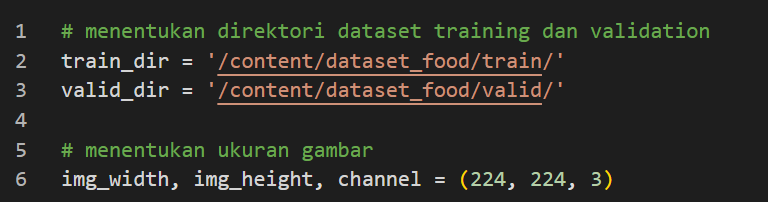

In [ ]:
# menentukan direktori dataset training dan validation
train_dir = '/content/dataset_food/train/'
valid_dir = '/content/dataset_food/valid/'

# menentukan ukuran gambar
img_width, img_height, channel = (224, 224, 3)

## Melakukan Data Generator

Selanjutnya, kita melakukan data generator yang berisi perintah untuk melakukan **data augmentasi**, menentukan besar **batch size**, ukuran gambar, dan **class mode**. Proses data generator dilakukan pada *train* dan *validation* dataset kita.

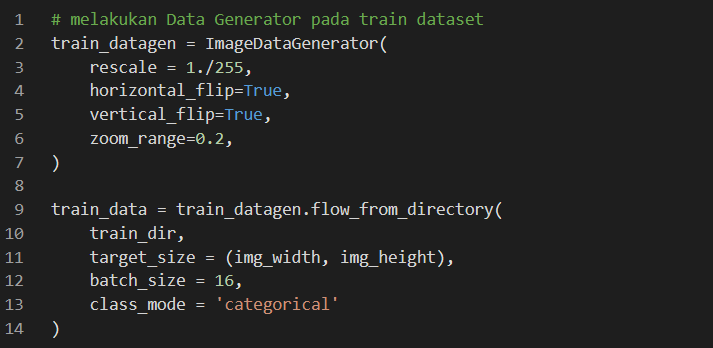

In [ ]:
# melakukan Data Generator pada train dataset
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 3949 images belonging to 5 classes.


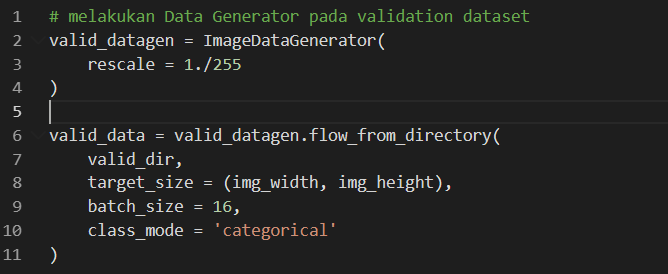

In [ ]:
# melakukan Data Generator pada validation dataset
valid_datagen = ImageDataGenerator(
    rescale = 1./255
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (img_width, img_height),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 902 images belonging to 5 classes.


## Import Pre-Trained Model

Karena kita menggunakan teknik Transfer Learning, maka perlu pretrained model. Pada sesi ini kita akan menggunakan pretrained model VGG dan MobileNet yang telah disediakan oleh Tensorflow.

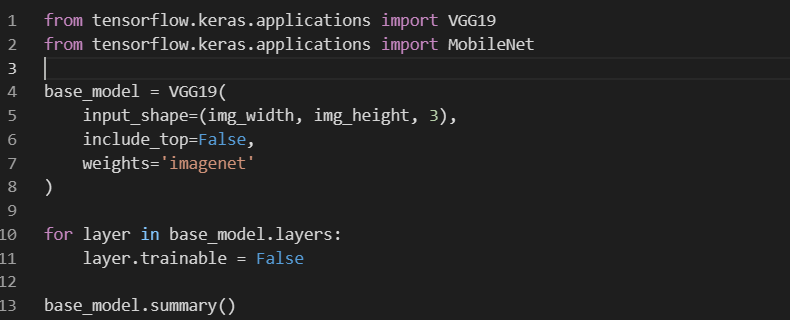

In [ ]:
# lakukan proses import pre-trained model seperti contoh di atas
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNet

base_model = VGG19(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

Selanjutnya, kita akan menambahkan beberapa **Dense Layer** dari Pretrained Model kita sesuai dengan kebutuhan kita. Kali ini kita akan menambahkan 2 **Dense Layer** pada Hidden Layer dengan **Dropout** layer dan Output layer berukuran 5 *(sesuai jumlah label)* dengan aktivasi **Softmax**.

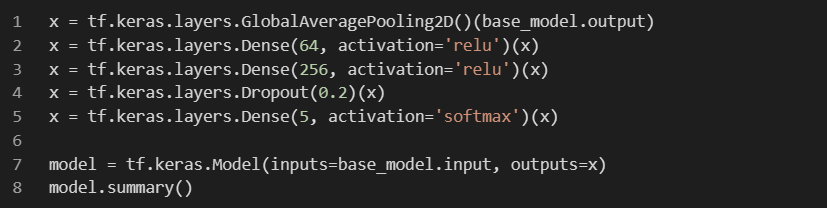

In [ ]:
# lakukan proses penambahan layer seperti contoh di atas
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation ='relu')(x)
x = tf.keras.layers.Dense(256, activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,075,141 (76.58 MB)

 Trainable params: 50,757 (198.27 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

## Compile Model

Kita akan melakukan compile model dengan menggunakan **Optimizer Adam** dengan **Learning-rate** sebanyak 0,001 dan loss menggunakan **Categorical Cross Entropy**.

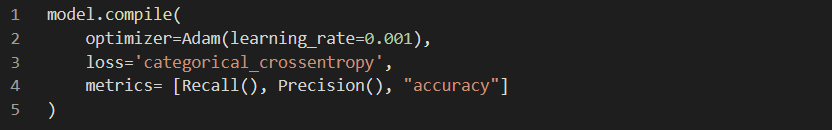

In [ ]:
# lakukan proses compile model seperti contoh diatas
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

## Membuat Callback dan Fit Model

kita akan membuat **Callback**, pada sesi ini kita gunakan **Early Stopping Callback** yang berfungsi untuk menghentikan proses training jika terpenuhi suatu kondisi. Kondisi yang kita buat pada callback kita kali ini adalah saat **Loss** tidak ada penurunan pada 3 epoch terakhir. Kemudian kita akan fit model dengan menggunakan epoch sebanyak 20.

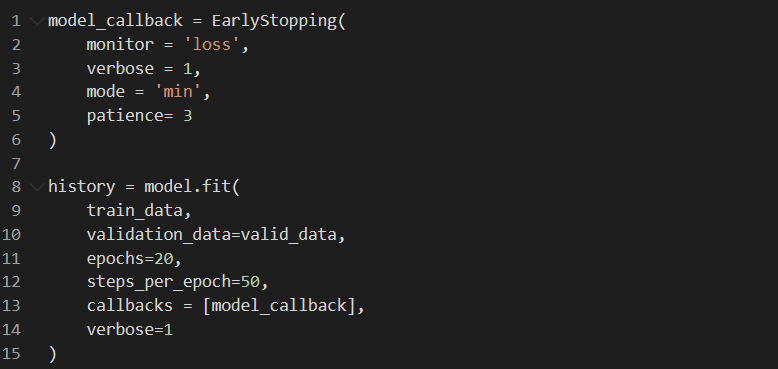

In [ ]:
# lakukan proses pembuatan callback dan fit model seperti contoh diatas
model_callback = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    mode = 'min',
    patience= 3
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    steps_per_epoch=50,
    callbacks = [model_callback],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1368s 28s/step - accuracy: 0.2895 - loss: 1.5721 - precision: 0.0588 - recall: 1.2305e-04 - val_accuracy: 0.5244 - val_loss: 1.3154 - val_precision: 1.0000 - val_recall: 0.0055
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1331s 27s/step - accuracy: 0.4815 - loss: 1.3402 - precision: 0.6704 - recall: 0.0569 - val_accuracy: 0.7029 - val_loss: 0.9879 - val_precision: 0.8837 - val_recall: 0.3537
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6010 - loss: 1.0808 - precision: 0.7607 - recall: 0.2968 

## Evaluasi

Kita dapat mengecek apakah model kita overfitting, underfitting, atau goodfitting menggunakan grafik berikut yang menunjukkan nilai akurasi disetiap epoch.

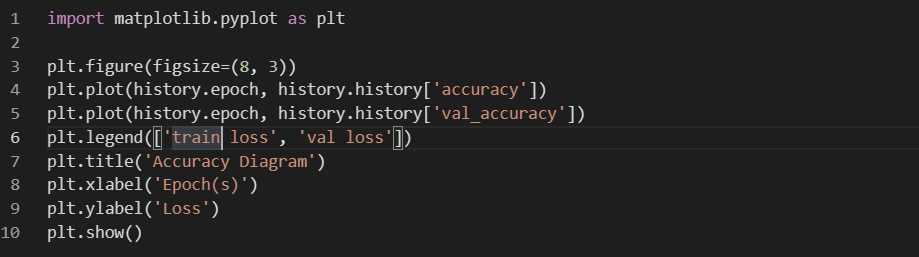

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['train loss', 'val loss'])
plt.title('Accuracy Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

## Save Model

Setelah kita telah mengevaluasi model dan mendapatkan hasil yang baik, Jangan lupa untuk menyimpan model tersebut dengan tipe file h5.

In [ ]:
# menyimpan model
model.save('myModel.h5')

## Load Model

Kita akan menggunakan model simpanan kita tadi untuk memprediksi sebuah gambar

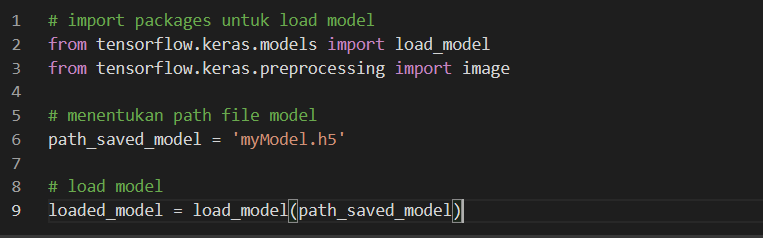

In [ ]:
# import packages untuk load model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# menentukan path file model
path_saved_model = 'myModel.h5'

# load model
loaded_model = load_model(path_saved_model)

## Predict!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  img_path = '/content/' + fn
  img = image.load_img(img_path, target_size=(224, 224));
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  classes = loaded_model.predict(img_array/255);

  for i, class_ in enumerate(classes[0]):
      if class_ == classes[0].max():
          if i == 0:
              print("bakso")
          elif i == 1:
              print("gudeg")
          elif i == 2:
              print("gado")
          elif i == 3:
              print("rendang")
          else:
              print("sate")